# 1 Imports

In [1]:
import pandas as pd
import sys
# from hurry.filesize import size
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import seaborn as sea
from datetime import datetime
from datetime import date
import datetime
from scipy.interpolate import interp1d
# from matplotlib.dates import AutoDateFormatter, AutoDateLocator

# 2 Load datasets from local files 

In [2]:
cpd_df = pd.read_csv("Public_CPD_Arrests.csv")
r_cpd_df = cpd_df[18580:23980] #crime during track of covid data
# r_cpd_df = cpd_df #alternatively, use everything from the first record to the last
del(cpd_df) #conserve memory
cov_df = pd.read_csv("time_series_covid19_confirmed_US.csv")
r_cov_df = cov_df.loc[(cov_df['Province_State'] == 'Tennessee') & (cov_df['Admin2'] == 'Hamilton')] #covid data for Hamilton county, TN
del(cov_df) #conserve memory

# 3 Exploring CPD data 

Exploring the CPD arrests data is done, by default, with only the indexes that align with the Covid-19 data by start and end date. This is done so that any visualizations or statistics can be more accurately compared between the two, as they are measured over the same period.

## 3.1 Arrange dataframe with date timestamps as indexes and crimes as columns

This block creates the t_cpd_df dataframe, which conveniently prepares the data for plotting over a range of dates. However, plotting the dataframe outright is going to look pretty awful, so don't try it.

In [3]:
crime_dict_by_date = {} #perform tracking per date
# start = time.time() #performance measurement
# cnt = 0 #performance measurement

#23992 total for full dataset, 5400 total for covid-19 track only
for i,s in tqdm(r_cpd_df.iterrows(),total=5400,desc='CPD Arrest Data Rows',unit='rows'):
    date = s['Arrest Date'][:9].strip()
    charges = list(set(list(map(str.strip,s['Charges'].split(',')))))
    for c in charges:
        if date not in crime_dict_by_date: #date not present, add it and the first crime
            crime_dict_by_date[date] = {c:1}
            crime_dict_by_date[date]['TOTAL_DAILY_CRIMES'] = 1
        else: #date present
            if c not in crime_dict_by_date[date]: #crime sub-key not present, add crime sub-key
                crime_dict_by_date[date][c] = 1
                crime_dict_by_date[date]['TOTAL_DAILY_CRIMES'] += 1
            else: #crime sub-key present, increment crime sub-key
                crime_dict_by_date[date][c] += 1
                crime_dict_by_date[date]['TOTAL_DAILY_CRIMES'] += 1
#     cnt += 1

cpd_df = pd.DataFrame.from_dict(crime_dict_by_date)
cpd_df.fillna(0,inplace=True)
cpd_df.sort_values(by=['1/22/2020'],inplace=True,ascending=False)
cpd_df.drop(cpd_df.tail(1).index,inplace=True)
t_cpd_df = cpd_df.transpose()

t_cpd_df.reset_index(inplace=True)
t_cpd_df['index'] = pd.to_datetime(t_cpd_df['index']) #, errors='coerce' the errors parameter only applies when using full dataset
t_cpd_df.rename(columns={'index':'Date'},inplace=True)
t_cpd_df.set_index('Date',inplace=True)
# t_cpd_df.index = t_cpd_df.index.map(datetime.date.toordinal) #Converts from timestamp to date object. Makes analysis a bit easier.
# t_cpd_df.index = t_cpd_df.index.map(datetime.date.fromordinal)
t_cpd_df

CPD Arrest Data Rows: 100%|███████████████████████████████████████████████████| 5400/5400 [00:00<00:00, 12357.92rows/s]


TOTAL_DAILY_CRIMES  Serving Warrant  Drug Equipment Violation  \
Date                                                                        
2020-01-22                51.0             10.0                      10.0   
2020-01-23                43.0              4.0                       9.0   
2020-01-24                19.0              6.0                       0.0   
2020-01-25                28.0              2.0                       3.0   
2020-01-26                66.0              3.0                       5.0   
...                        ...              ...                       ...   
2020-09-11                40.0              6.0                       3.0   
2020-09-12                44.0              8.0                       2.0   
2020-09-13                23.0              5.0                       1.0   
2020-09-14                16.0              0.0                       2.0   
2020-09-15                50.0              5.0                       6.0   

            Drugs/Narcotics Violation/Felony  All Other Traffic Offenses  \
Date                                                                       
2020-01-22                               7.0                         4.0   
2020-01-23                              11.0                         2.0   
2020-01-24                               0.0                         0.0   
2020-01-25                               1.0                         2.0   
2020-01-26                               4.0                         4.0   
...                                      ...                         ...   
2020-09-11                               3.0                         0.0   
2020-09-12                               3.0                         3.0   
2020-09-13                               1.0                         2.0   
2020-09-14                               3.0                         0.0   
2020-09-15                               5.0                         0.0   

            Miscellaneous  Other  Trespass of Real Property  \
Date                                                          
2020-01-22            4.0    4.0                        2.0   
2020-01-23            1.0    1.0                        4.0   
2020-01-24            2.0    0.0                        1.0   
2020-01-25            3.0    2.0                        2.0   
2020-01-26            7.0    4.0                        3.0   
...                   ...    ...                        ...   
2020-09-11            5.0    2.0                        1.0   
2020-09-12            2.0    0.0                        2.0   
2020-09-13            1.0    0.0                        0.0   
2020-09-14            2.0    1.0                        0.0   
2020-09-15            5.0    1.0                        2.0   

            Aggravated Assault  Disorderly Conduct  ...  Forcible Rape  \
Date                                                ...                  
2020-01-22                 1.0                 1.0  ...            0.0   
2020-01-23                 0.0                 1.0  ...            0.0   
2020-01-24                 0.0                 1.0  ...            0.0   
2020-01-25                 0.0                 0.0  ...            0.0   
2020-01-26                 0.0                 4.0  ...            0.0   
...                        ...                 ...  ...            ...   
2020-09-11                 2.0                 1.0  ...            0.0   
2020-09-12                 0.0                 2.0  ...            0.0   
2020-09-13                 0.0                 0.0  ...            0.0   
2020-09-14                 1.0                 1.0  ...            0.0   
2020-09-15                 0.0                 1.0  ...            0.0   

            Simple Assault/DV  Theft & Recovery/Passenger Vehicle  \
Date                                                                
2020-01-22                0.0                                 0.0   
2020-01-23                0.0  

In [4]:
t_cpd_df.index[0]

Timestamp('2020-01-22 00:00:00')

## 3.2 Explore CPD data with statistics

### 3.2.1 Explore by crime

The data is normally formatted for plotting, so getting descriptive statistics from it requires the replacement of all zeroes with NaNs. This is done on a copy, so the later plotting code blocks are unaffected by this.

In [ ]:
cpy = t_cpd_df.copy(deep=True)
cpy.replace(0,np.nan,inplace=True)
cpy.describe()

It is also possible to explore the data by specific crimes.

In [ ]:
cpy['TOTAL_DAILY_CRIMES'].describe()

In the code block below, you can pick which crime you'd like to learn more about. The code will show you all results that contain the term you enter, so entering "burg" will return all results related to burglary, while "a" will likely return most if not all the crimes, given that their names include the letter "a." Keep in mind that these are not the measurements of that crime on specific days, but rather across all days from Jan 22, 2020 to Sep 15, 2020.

In [ ]:
crimes = t_cpd_df.columns
hlp = '/c\tList out available crimes to search.\n-------------------------------------------\n'
print(hlp)

term = input('Search for: ')

if term == '/c':
    for index,crime in enumerate(crimes):
        print('{}\t{}'.format(index+1,crime))
    exit
else:
    matches = []
    for crime in crimes:
        if term.lower() in crime.lower(): matches.append(crime)
        else: continue
    if not matches:
        print('There were no results. Try again.')
        exit
    else:
        for match in matches:
#             print(cpy[match].describe())
            display(cpy[match].describe())
#             print('\n\n')

### 3.2.2 Explore by time period

The original t_cpd_df dataframe is used here.

You can search for a specific range of values across the given time frame.

In [ ]:
print('Enter your chosen year, month, and day to search. Use YYYY-MM-DD format. Preface single digits with 0.\n\nThe available timeframe is from {} to {}'.format(str(t_cpd_df.index[0]),str(t_cpd_df.index[-1])))
start = input('Starting date: ')
end = input('Ending date: ')

# start_list = start.split('-')
# end_list = end.split('-')

# start = datetime.date(int(start_list[2]),int(start_list[0]),int(start_list[1]))
# end = datetime.date(int(end_list[2]),int(end_list[0]),int(end_list[1]))

print('Choose to show dataframe view or statistical view. Enter DF for dataframe and ST for statistics.')
op = input('Choice: ')
if op == 'DF': display(t_cpd_df[start:end])
elif op == 'ST': display(t_cpd_df[start:end].describe())
else:
    print('Unrecognized choice. Defaulting to dataframe.')
    display(t_cpd_df[start:end])

## 3.3 Explore data through visualization

### 3.3.1 Linear Regression: Crime vs. Time

The two code blocks below will show trendlines for each crime, as well as the scatterplot upon which that trendline is drawn. Two versions are provided, one that is faster at the expense of using more RAM, and vice versa.

#### 3.3.1a Make plots for crimes (Faster, RAM intensive)

In [ ]:
#CHANGE COLOR OF TRENDLINE AND DOTS
plt.rcParams.update({'figure.max_open_warning': 0})
cpy = t_cpd_df.copy(deep=True)
t = len(cpy.columns)
x = 'Date'
y = 'Frequency of Arrests'
cpy.index = cpy.index.map(datetime.date.toordinal)

for col in tqdm(cpy,total=t,desc='CPD Scatterplots with Trendlines',unit='figures'):
    plt.figure()
    s = sea.regplot(cpy.index,cpy[col],data=cpy,color='Red',scatter_kws={"color": "blue"})
    ax = plt.gca()
    xticks = ax.get_xticks()
    xticks_dates = [datetime.date.fromordinal(int(x)) for x in xticks]
    ax.set_xticklabels(xticks_dates)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(col)

# cpy.index = cpy.index.map(datetime.date.fromordinal)
plt.show()
plt.close('all') #close all figures to prevent memory leak

In [ ]:
print(t_cpd_df.index[0])
print(type(t_cpd_df.index[0]))

In [ ]:
t_cpd_df

#### 3.3.1b Make plots for crimes (Slower, easier on RAM)

In [ ]:
cpy = t_cpd_df.copy(deep=True)
cpy.index = cpy.index.map(datetime.date.toordinal)
plt.figure()
x = 'Dates'
y = 'Frequency of Arrests'

for col in cpy:
    sea.regplot(cpy.index,cpy[col],data=cpy,color='Red',scatter_kws={"color": "blue"})
    ax = plt.gca()
    xticks = ax.get_xticks()
    xticks_dates = [datetime.date.fromordinal(int(x)) for x in xticks]
    ax.set_xticklabels(xticks_dates)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(col)
    plt.show()

# t_cpd_df.index = t_cpd_df.index.map(datetime.date.fromordinal)

In [ ]:
t_cpd_df

### 3.3.2 Line plot of CPD data

The trendlines previously shown were good for seeing the general tendencies of the crimes over the whole given timespan, but seeing the change between the individual scatterplot points was a bit difficult. A line plot helps to show the change between points a bit better. Unfortunately, even with interpolation, the CPD arrests data is not smooth by its very nature, as arrests typically fluctuate between days to a great degree. Thus, the line plots of the CPD data are jagged and somewhat difficult to read, but the shape of the plots show trends from time to time, such as the fall, spike, fall, and smaller spike pattern of the TOTAL_DAILY_CRIMES plot.

In [27]:
#LOOK INTO ADDITIONAL SMOOTHING FUNCTIONS
cpy = t_cpd_df.copy(deep=True)

cpy.index = cpy.index.map(datetime.date.toordinal)
cpy.index = cpy.index.map(datetime.date.fromordinal) #Allows np.arange to work but breaks interp1d

indnp = cpy.index.map(datetime.date.toordinal)
indnp = indnp.map(datetime.date.fromordinal)

ind = np.arange(indnp[0],indnp[-1])
cpy.index = pd.to_datetime(cpy.index)
# print(type(ind[0]))
# print(type(cpy.index[0]))

plt.figure()
x = 'Dates'
y = 'Frequency of Arrests'
for col in cpy:
    tmp = pd.DataFrame()
#     ind = np.arange(ind[0],ind[-1])
    crime = interp1d(cpy.index,cpy[col],kind='cubic')
    tmp[col] = crime(ind)
    tmp.index = ind
    tmp.plot(rot=90)
    
#     cpy[col].plot(rot=90)

#     ax = plt.gca()
#     xticks = ax.get_xticks()
#     xticks_dates = [datetime.date.fromordinal(int(x)) for x in xticks]
#     ax.set_xticklabels(xticks_dates)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(col)
    plt.show()

TypeError: invalid type promotion

<Figure size 432x288 with 0 Axes>

# Prepare and plot Covid-19 data

<Figure size 432x288 with 0 Axes>

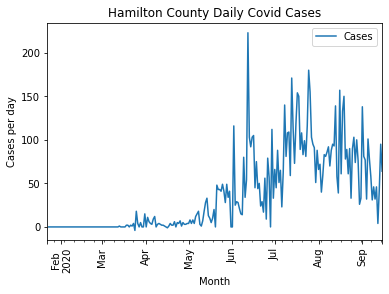

In [6]:
cov_df = r_cov_df.loc[:,'1/22/2020':]
t_cov_df = cov_df.transpose()
t_cov_df.rename(columns={t_cov_df.columns[0]:'Cases'}, inplace=True)
t_cov_df = t_cov_df.diff(axis=0)

t_cov_df.reset_index(inplace=True)
t_cov_df['index'] = pd.to_datetime(t_cov_df['index'])
t_cov_df.rename(columns={'index':'Date'},inplace=True)
t_cov_df.set_index('Date',inplace=True)
# t_cov_df.index = t_cov_df.index.map(datetime.date.toordinal)
# t_cov_df.index = t_cov_df.index.map(datetime.date.fromordinal)
# t_cov_df.replace(np.nan,0,inplace=True)
# t_cov_df.interpolate(method='spline',order=5,inplace=True)

plt.figure()
t_cov_df.plot(rot=90)
plt.xlabel('Month')
plt.ylabel('Cases per day')
plt.title('Hamilton County Daily Covid Cases')
plt.show()

# Overlay frequency in CPD and daily cases in Covid

In [ ]:
t_cpd_df

In [ ]:
t_cov_df

CPD/Covid Overlay Plots: 100%|████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.18figures/s]


<Figure size 432x288 with 0 Axes>

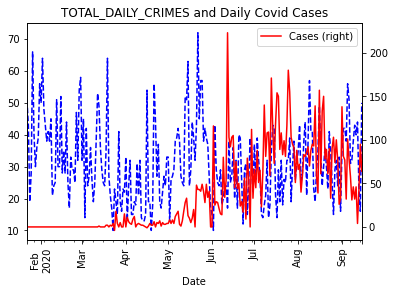

<Figure size 432x288 with 0 Axes>

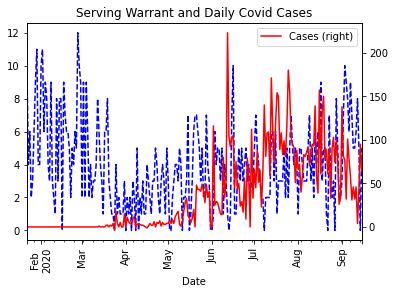

<Figure size 432x288 with 0 Axes>

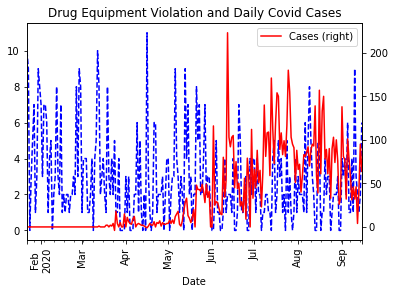

<Figure size 432x288 with 0 Axes>

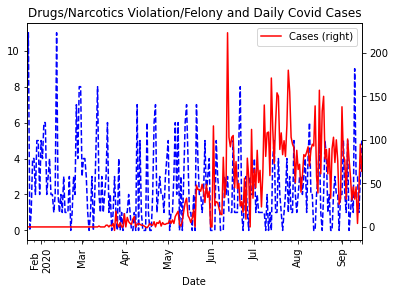

<Figure size 432x288 with 0 Axes>

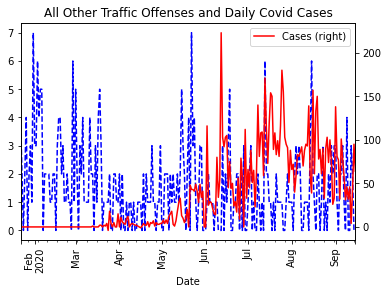

<Figure size 432x288 with 0 Axes>

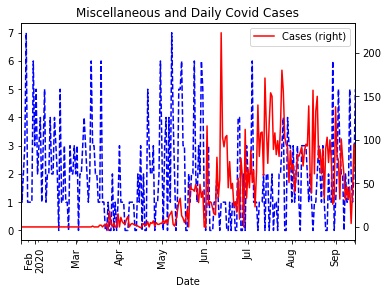

<Figure size 432x288 with 0 Axes>

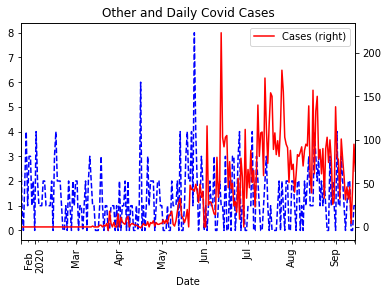

<Figure size 432x288 with 0 Axes>

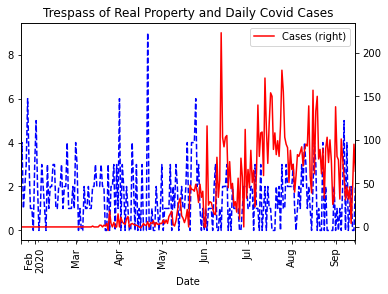

<Figure size 432x288 with 0 Axes>

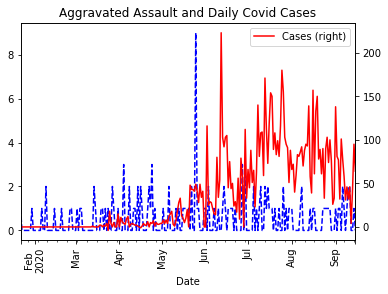

<Figure size 432x288 with 0 Axes>

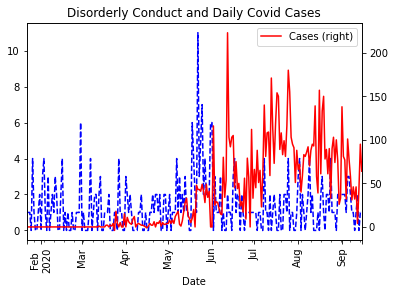

<Figure size 432x288 with 0 Axes>

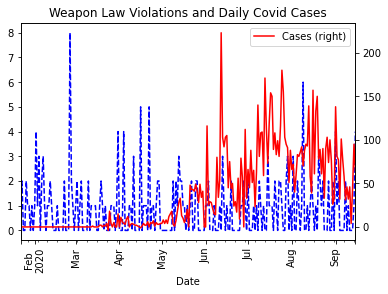

<Figure size 432x288 with 0 Axes>

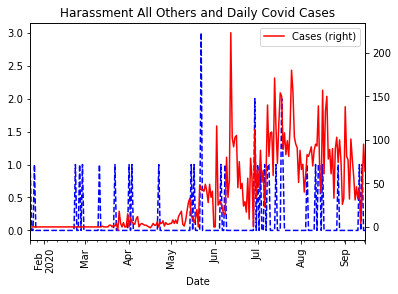

<Figure size 432x288 with 0 Axes>

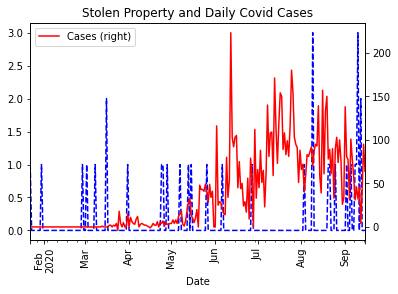

<Figure size 432x288 with 0 Axes>

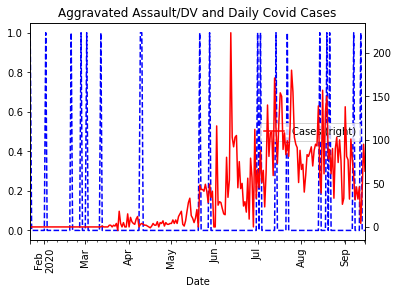

<Figure size 432x288 with 0 Axes>

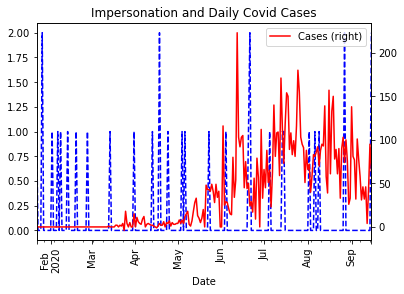

<Figure size 432x288 with 0 Axes>

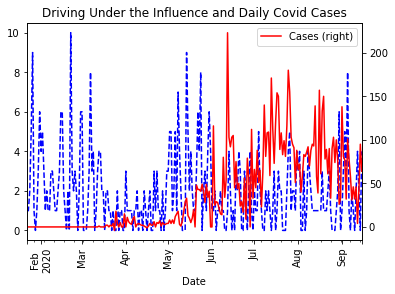

<Figure size 432x288 with 0 Axes>

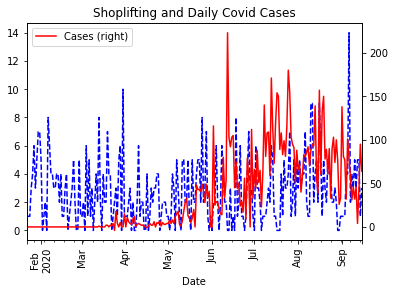

<Figure size 432x288 with 0 Axes>

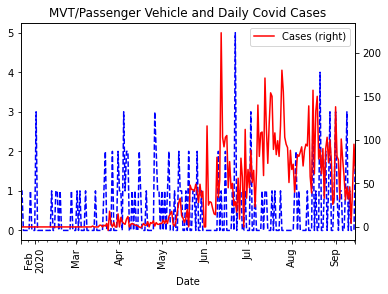

<Figure size 432x288 with 0 Axes>

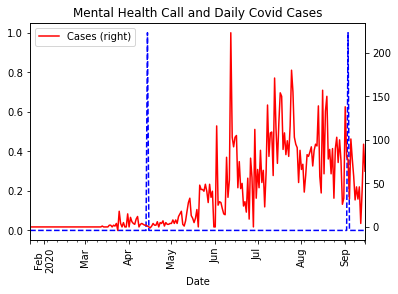

<Figure size 432x288 with 0 Axes>

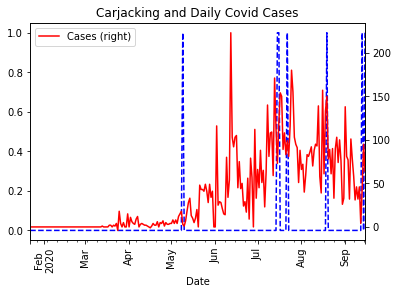

<Figure size 432x288 with 0 Axes>

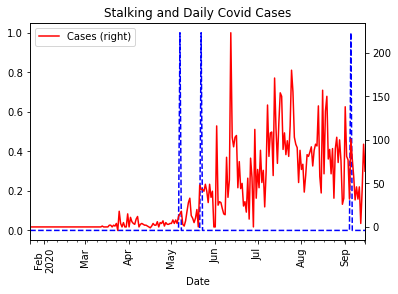

<Figure size 432x288 with 0 Axes>

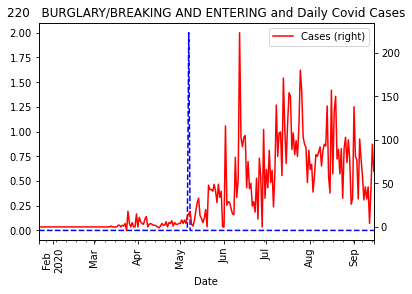

<Figure size 432x288 with 0 Axes>

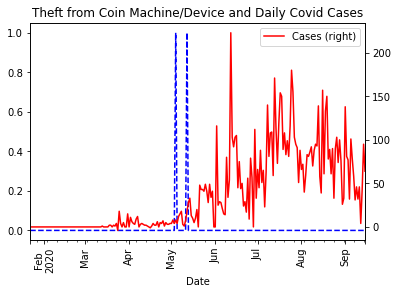

<Figure size 432x288 with 0 Axes>

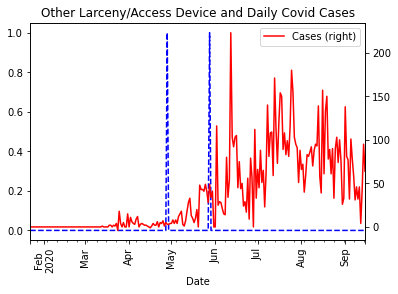

<Figure size 432x288 with 0 Axes>

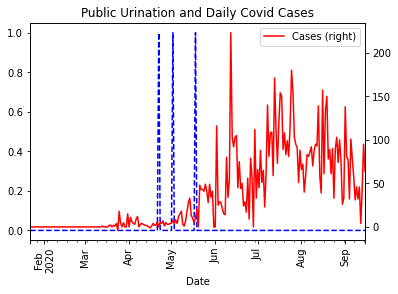

<Figure size 432x288 with 0 Axes>

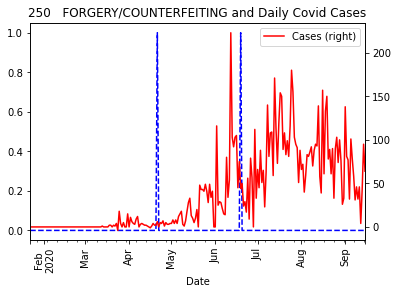

<Figure size 432x288 with 0 Axes>

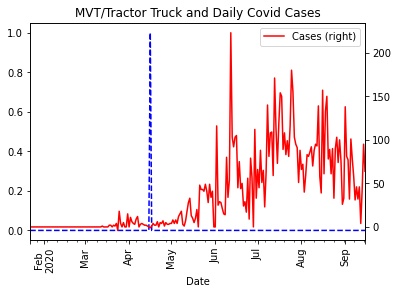

<Figure size 432x288 with 0 Axes>

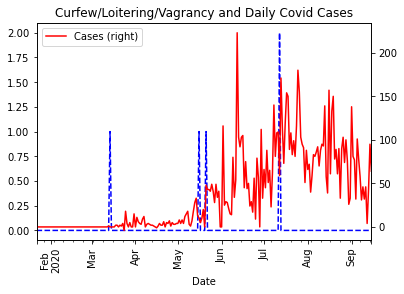

<Figure size 432x288 with 0 Axes>

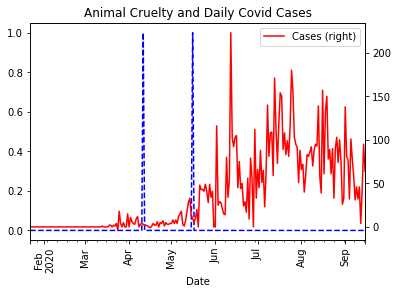

<Figure size 432x288 with 0 Axes>

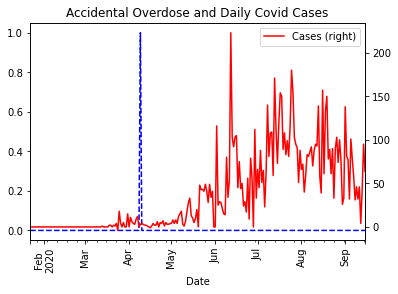

<Figure size 432x288 with 0 Axes>

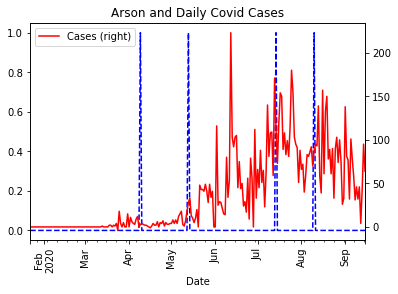

<Figure size 432x288 with 0 Axes>

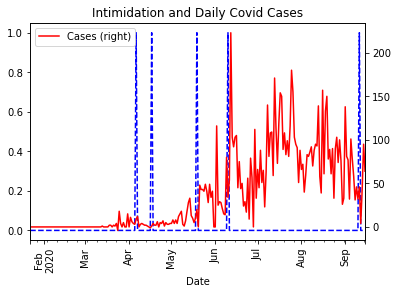

<Figure size 432x288 with 0 Axes>

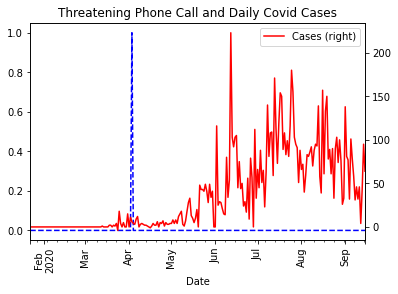

<Figure size 432x288 with 0 Axes>

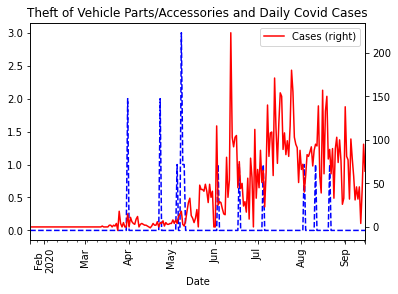

<Figure size 432x288 with 0 Axes>

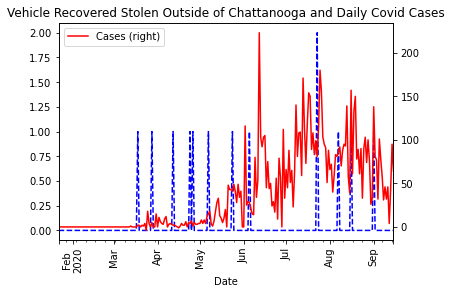

<Figure size 432x288 with 0 Axes>

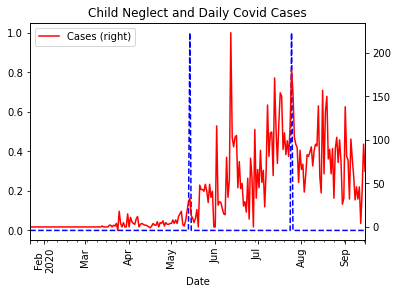

<Figure size 432x288 with 0 Axes>

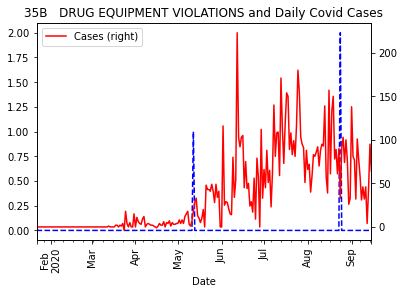

<Figure size 432x288 with 0 Axes>

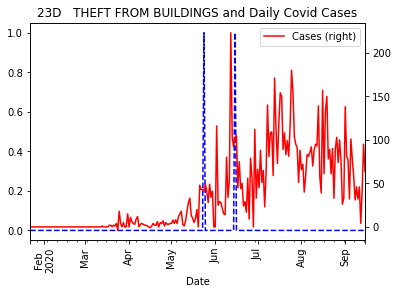

<Figure size 432x288 with 0 Axes>

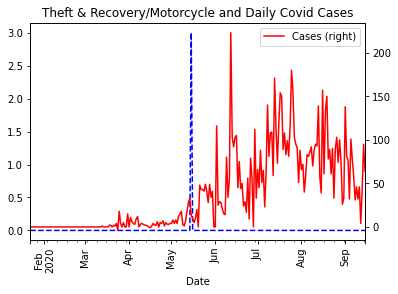

<Figure size 432x288 with 0 Axes>

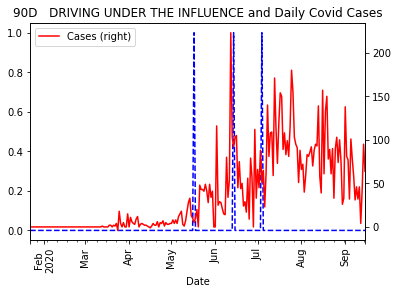

<Figure size 432x288 with 0 Axes>

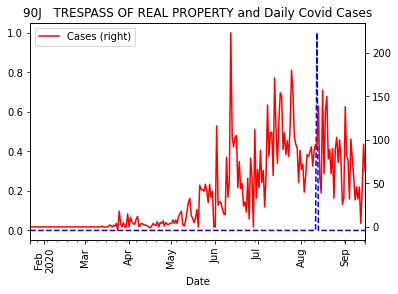

<Figure size 432x288 with 0 Axes>

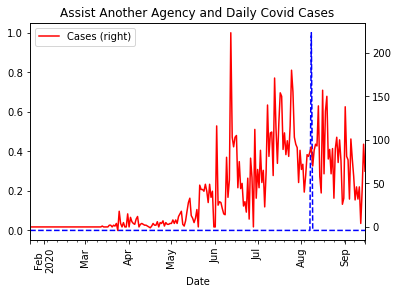

<Figure size 432x288 with 0 Axes>

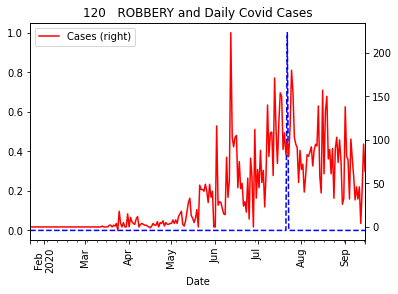

<Figure size 432x288 with 0 Axes>

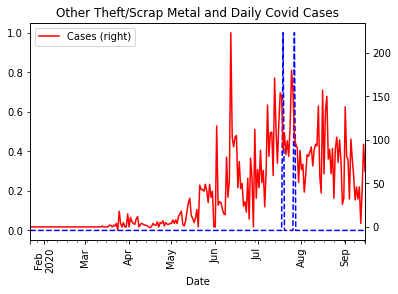

<Figure size 432x288 with 0 Axes>

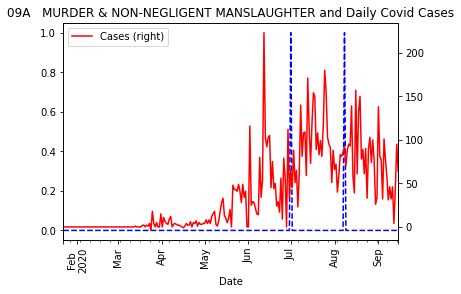

<Figure size 432x288 with 0 Axes>

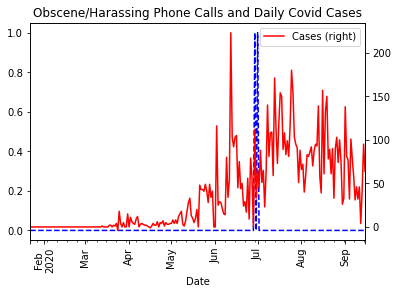

<Figure size 432x288 with 0 Axes>

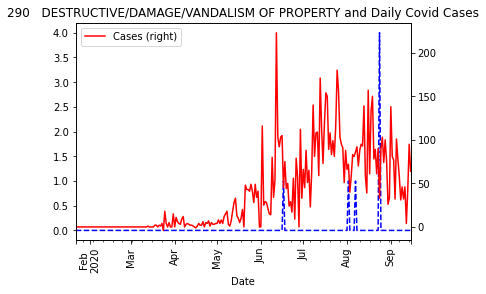

<Figure size 432x288 with 0 Axes>

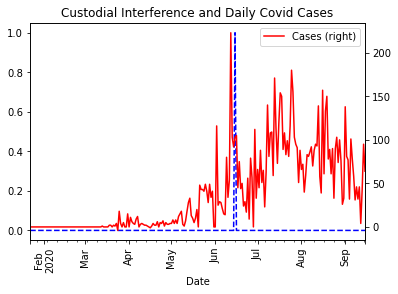

<Figure size 432x288 with 0 Axes>

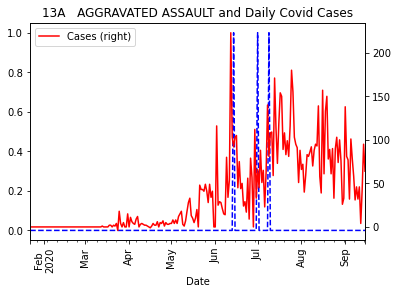

<Figure size 432x288 with 0 Axes>

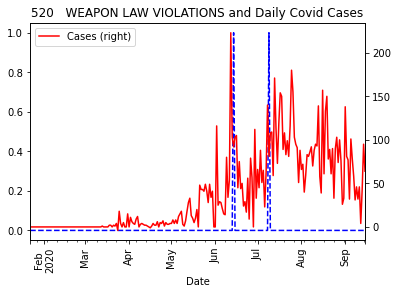

<Figure size 432x288 with 0 Axes>

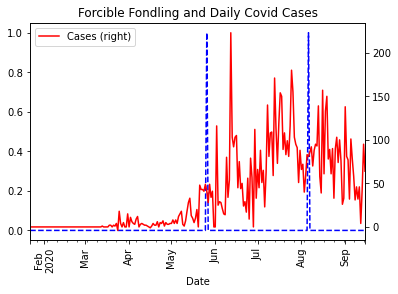

<Figure size 432x288 with 0 Axes>

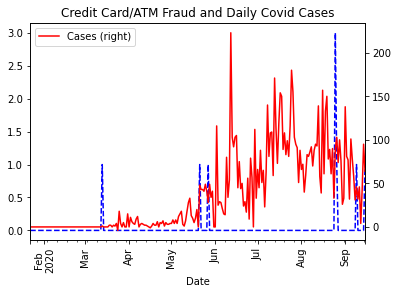

<Figure size 432x288 with 0 Axes>

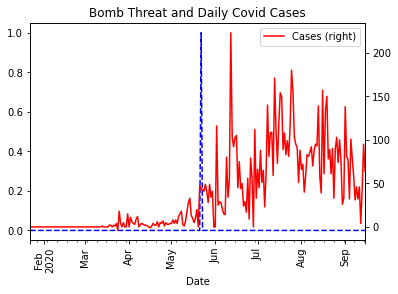

<Figure size 432x288 with 0 Axes>

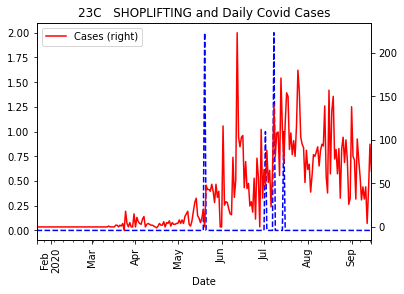

<Figure size 432x288 with 0 Axes>

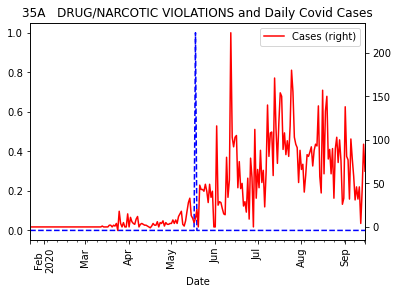

<Figure size 432x288 with 0 Axes>

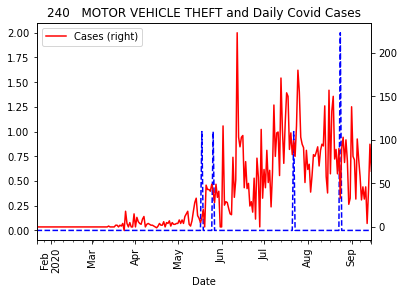

<Figure size 432x288 with 0 Axes>

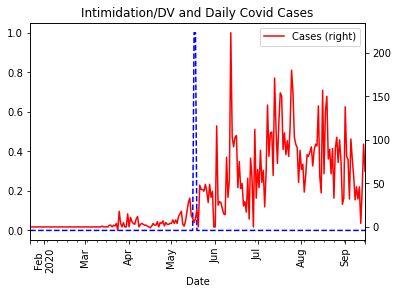

<Figure size 432x288 with 0 Axes>

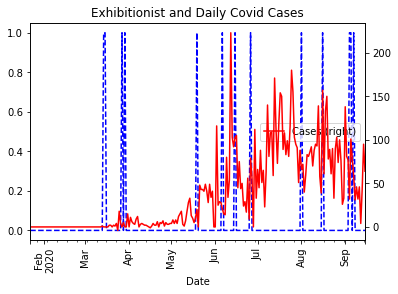

<Figure size 432x288 with 0 Axes>

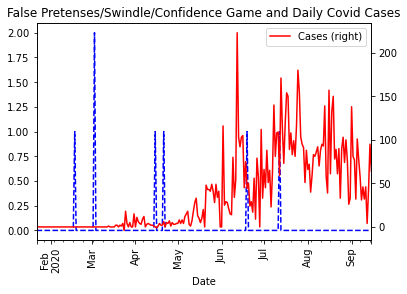

<Figure size 432x288 with 0 Axes>

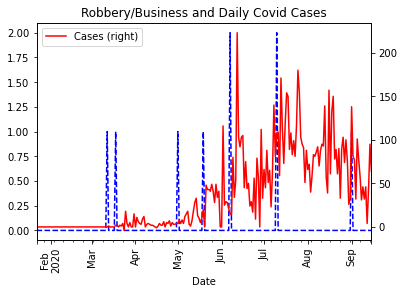

<Figure size 432x288 with 0 Axes>

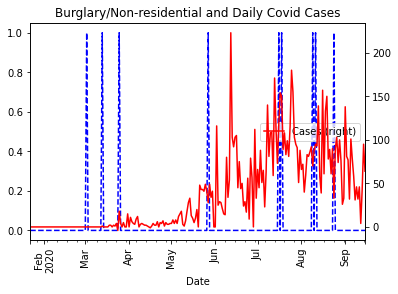

<Figure size 432x288 with 0 Axes>

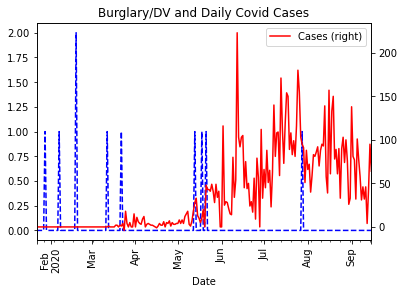

<Figure size 432x288 with 0 Axes>

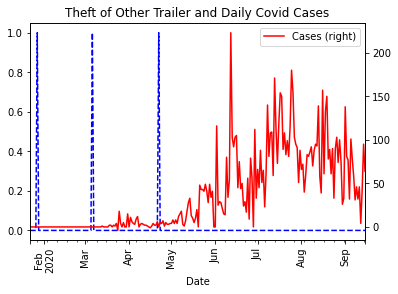

<Figure size 432x288 with 0 Axes>

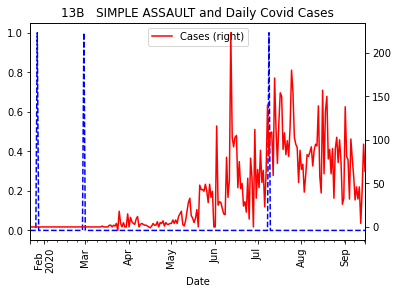

<Figure size 432x288 with 0 Axes>

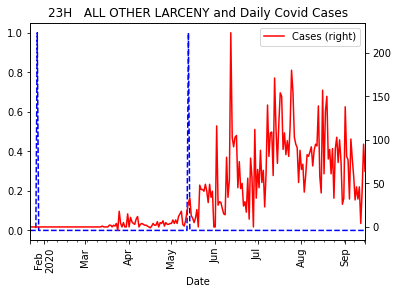

<Figure size 432x288 with 0 Axes>

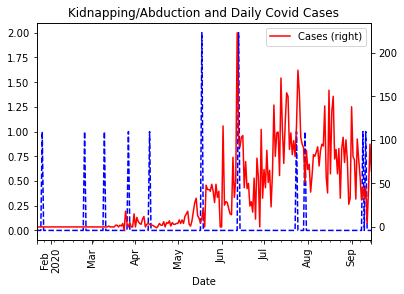

<Figure size 432x288 with 0 Axes>

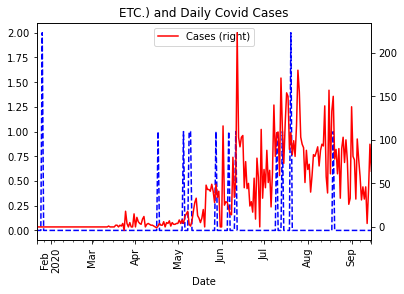

<Figure size 432x288 with 0 Axes>

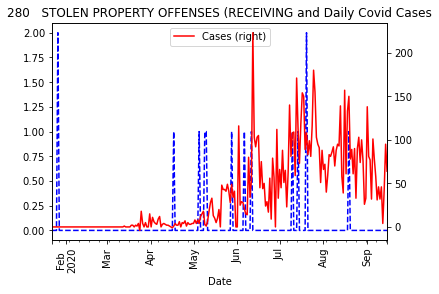

<Figure size 432x288 with 0 Axes>

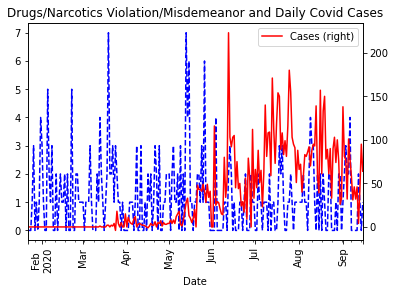

<Figure size 432x288 with 0 Axes>

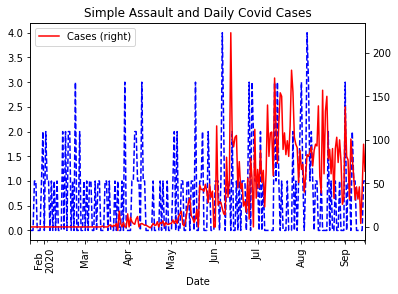

<Figure size 432x288 with 0 Axes>

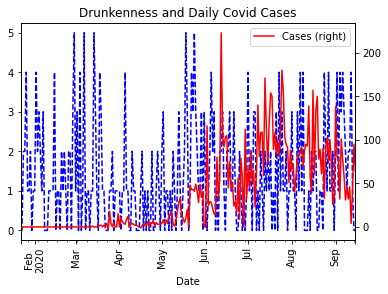

<Figure size 432x288 with 0 Axes>

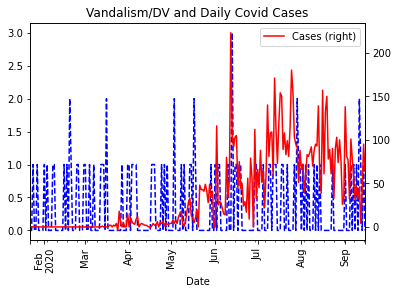

<Figure size 432x288 with 0 Axes>

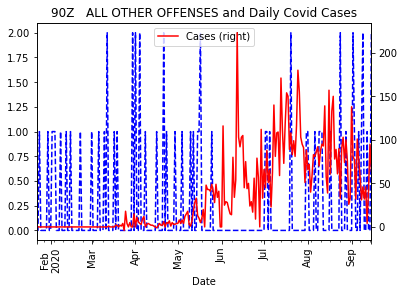

<Figure size 432x288 with 0 Axes>

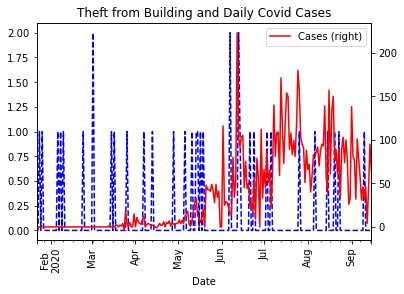

<Figure size 432x288 with 0 Axes>

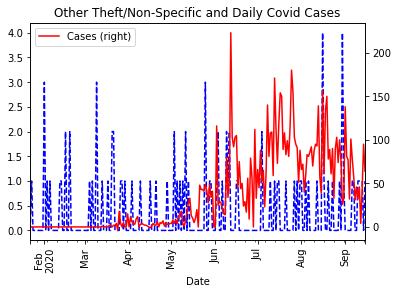

<Figure size 432x288 with 0 Axes>

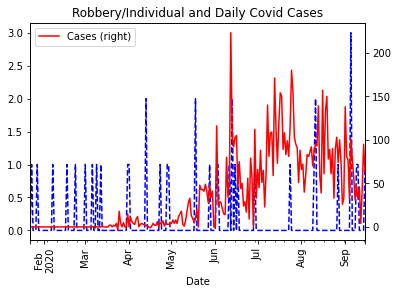

<Figure size 432x288 with 0 Axes>

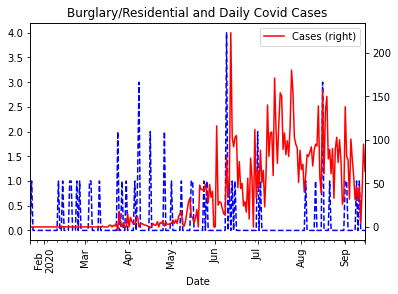

<Figure size 432x288 with 0 Axes>

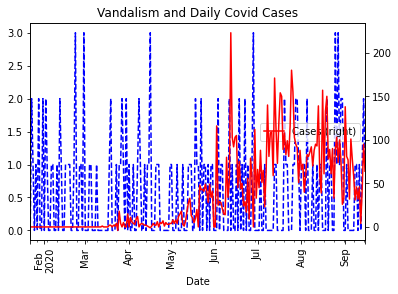

<Figure size 432x288 with 0 Axes>

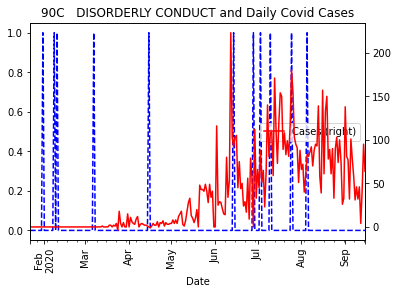

<Figure size 432x288 with 0 Axes>

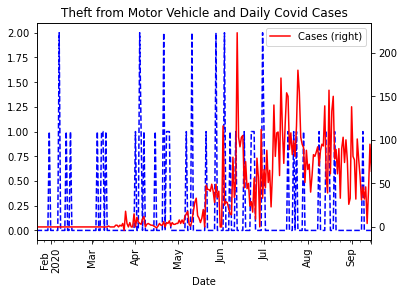

<Figure size 432x288 with 0 Axes>

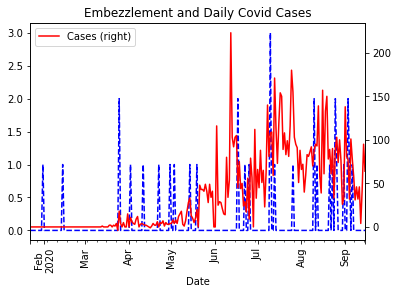

<Figure size 432x288 with 0 Axes>

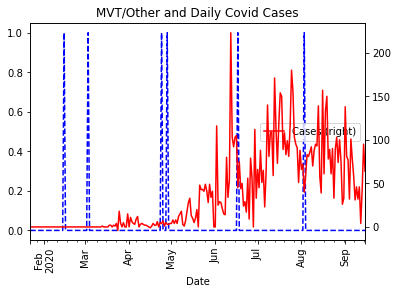

<Figure size 432x288 with 0 Axes>

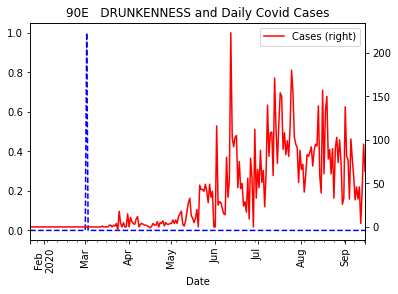

<Figure size 432x288 with 0 Axes>

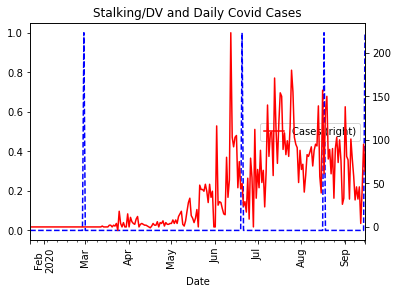

<Figure size 432x288 with 0 Axes>

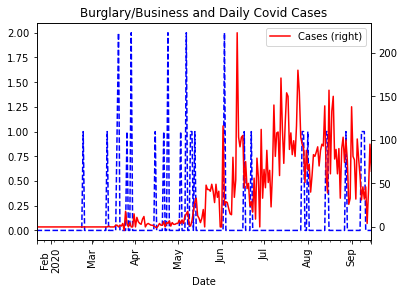

<Figure size 432x288 with 0 Axes>

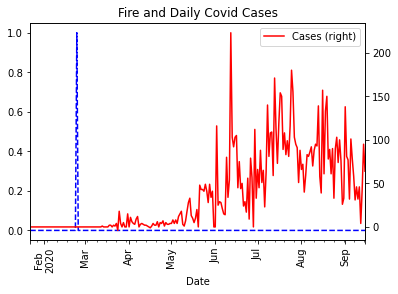

<Figure size 432x288 with 0 Axes>

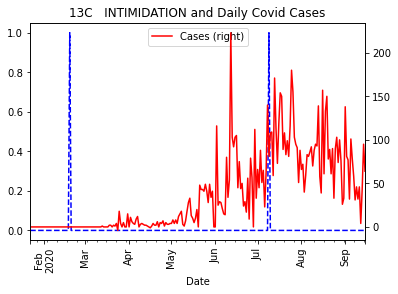

<Figure size 432x288 with 0 Axes>

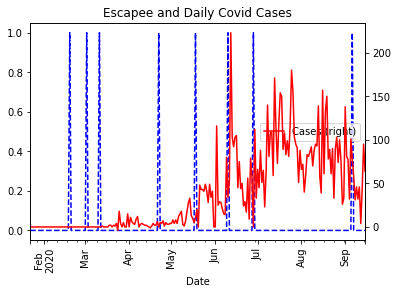

<Figure size 432x288 with 0 Axes>

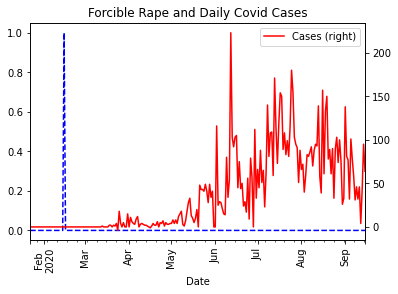

<Figure size 432x288 with 0 Axes>

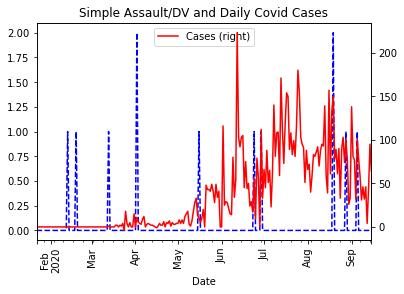

<Figure size 432x288 with 0 Axes>

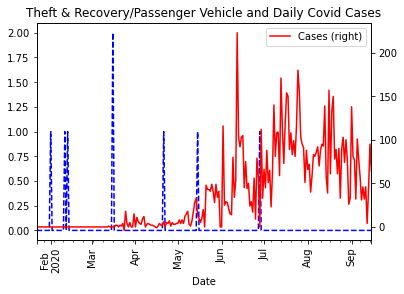

<Figure size 432x288 with 0 Axes>

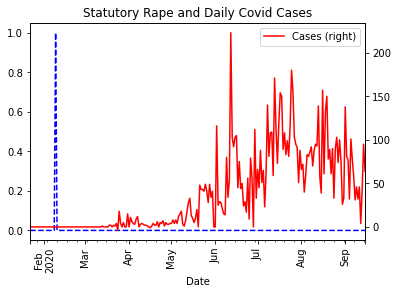

<Figure size 432x288 with 0 Axes>

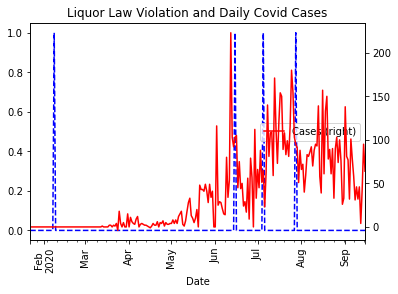

<Figure size 432x288 with 0 Axes>

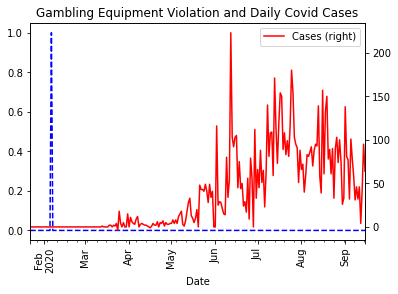

<Figure size 432x288 with 0 Axes>

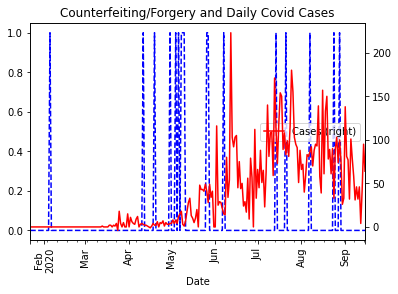

<Figure size 432x288 with 0 Axes>

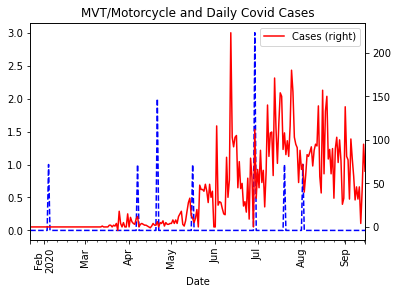

<Figure size 432x288 with 0 Axes>

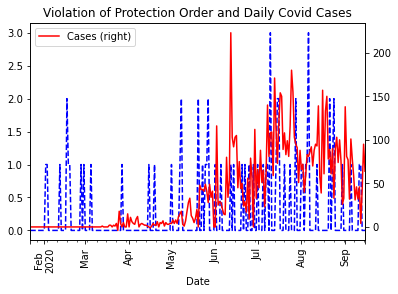

<Figure size 432x288 with 0 Axes>

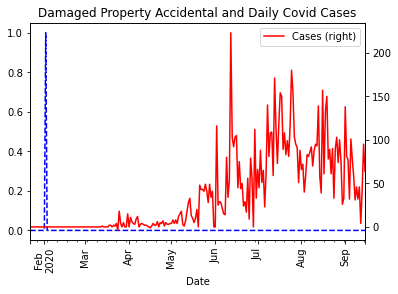

In [7]:
x = 'Dates'
# y = 'Frequency of Arrests'
plt.rcParams.update({'figure.max_open_warning': 0})
t = len(t_cpd_df.columns)
for crime in tqdm(t_cpd_df,total=t,desc='CPD/Covid Overlay Plots',unit='figures'):
    plt.figure()
    ax_cov = t_cov_df.plot(rot=90,secondary_y=True,style=['r']) #linestyle='--'
#     plt.ylabel(y)
    t_cpd_df[crime].plot(ax=ax_cov,rot=90,style=['b'],linestyle='--')
    plt.xlabel(x)
    plt.title(crime+' and Daily Covid Cases')
#     ax_cpd = t_cpd_df[crime].plot(rot=90,style=['b'])
#     t_cov_df.plot(ax=ax_cpd, style=['g'], linestyle='--')
#     plt.show()
plt.show()
plt.close('all') #close all figures to prevent memory leak

# Linear regression: Arrests vs. Daily Covid Cases

TODO